In [1]:
import numpy as np
import tensorflow as tf

from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2

In [2]:
from utils import generate_run_ID, load_model, load_model_folder
from place_cells import PlaceCells
from trajectory_generator import TrajectoryGenerator
from model import RNN, LSTM
from tqdm import tqdm_notebook as tqdm

In [3]:
# Training options and hyperparameters
class Options:
    pass
options = Options()

options.save_dir = 'models'
options.n_epochs = 100          # number of training epochs
options.n_steps = 1000        # batches per epoch
options.batch_size = 200      # number of trajectories per batch
options.sequence_length = 20  # number of steps in trajectory
options.learning_rate = 1e-4  # gradient descent learning rate
options.Np = 512              # number of place cells
options.Ng = 1024              # number of grid cells
options.place_cell_rf = 0.12  # width of place cell center tuning curve (m)
options.surround_scale = 2    # if DoG, ratio of sigma2^2 to sigma1^2
options.RNN_type = 'LSTM'      # RNN or LSTM
options.activation = 'relu'   # recurrent nonlinearity
options.weight_decay = 1e-4   # strength of weight decay on recurrent weights
options.DoG = True            # use difference of gaussians tuning curves
options.topology='plane'      # plane, torus or klein
options.box_width = 2.2       # width of training environment
options.box_height = 2.2      # height of training environment

options.run_ID = generate_run_ID(options)

In [4]:
options.run_ID

'steps_20_batch_200_LSTM_1024_relu_rf_012_DoG_True_plane_lr_00001_weight_decay_00001'

In [5]:
place_cells = PlaceCells(options)
model = RNN(options, place_cells)
trajectory_generator = TrajectoryGenerator(options, place_cells)
folder = '/home/simone/Desktop/Tesi/trained_models/lstm/steps_20_batch_200_LSTM_1024_relu_rf_012_DoG_True_periodic_False_lr_00001_weight_decay_00001/ckpts/'
model = load_model_folder(options, model, folder)

Restored trained model from /home/simone/Desktop/Tesi/trained_models/lstm/steps_20_batch_200_LSTM_1024_relu_rf_012_DoG_True_periodic_False_lr_00001_weight_decay_00001/ckpts/ckpt-101


In [6]:
#evaluate performance
inputs, pos, pc_outputs = trajectory_generator.get_test_batch()
true_pos = place_cells.get_nearest_cell_pos(pc_outputs)
pred_pos = place_cells.get_nearest_cell_pos(model.predict(inputs))

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
for i in range(5):
    plt.plot(pos[i,:,0], pos[i,:,1], c='black', label='True position', linewidth=2)
    plt.plot(pred_pos[i,:,0], pred_pos[i,:,1], '.-',
             c='C1', linestyle='dashed', label='Decoded position')
    if i==0:
        plt.legend()
plt.scatter(place_cells.us[:,0], place_cells.us[:,1], s=20, alpha=0.5, c='lightgrey')
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)
plt.xticks([])
plt.yticks([])
plt.xlim([-options.box_width/2,options.box_width/2])
plt.ylim([-options.box_height/2,options.box_height/2]);

ValueError: in converted code:
    relative to /home/simone:

    Desktop/Tesi/grid_code/neural_networks/model.py:58 call  *
        place_preds = self.decoder(self.g(inputs))
    Desktop/Tesi/grid_code/neural_networks/model.py:43 g  *
        g = self.RNN(v, initial_state=init_state)
    anaconda3/envs/gc/lib/python3.7/site-packages/tensorflow_core/python/keras/layers/recurrent.py:673 __call__
        return super(RNN, self).__call__(inputs, **kwargs)
    anaconda3/envs/gc/lib/python3.7/site-packages/tensorflow_core/python/keras/engine/base_layer.py:817 __call__
        self._maybe_build(inputs)
    anaconda3/envs/gc/lib/python3.7/site-packages/tensorflow_core/python/keras/engine/base_layer.py:2141 _maybe_build
        self.build(input_shapes)
    anaconda3/envs/gc/lib/python3.7/site-packages/tensorflow_core/python/keras/layers/recurrent.py:544 build
        self.cell.build(step_input_shape)
    anaconda3/envs/gc/lib/python3.7/site-packages/tensorflow_core/python/keras/utils/tf_utils.py:306 wrapper
        output_shape = fn(instance, input_shape)
    anaconda3/envs/gc/lib/python3.7/site-packages/tensorflow_core/python/keras/layers/recurrent.py:1194 build
        constraint=self.kernel_constraint)
    anaconda3/envs/gc/lib/python3.7/site-packages/tensorflow_core/python/keras/engine/base_layer.py:522 add_weight
        aggregation=aggregation)
    anaconda3/envs/gc/lib/python3.7/site-packages/tensorflow_core/python/training/tracking/base.py:725 _add_variable_with_custom_getter
        name=name, shape=shape)
    anaconda3/envs/gc/lib/python3.7/site-packages/tensorflow_core/python/training/tracking/base.py:792 _preload_simple_restoration
        checkpoint_position=checkpoint_position, shape=shape)
    anaconda3/envs/gc/lib/python3.7/site-packages/tensorflow_core/python/training/tracking/base.py:75 __init__
        self.wrapped_value.set_shape(shape)
    anaconda3/envs/gc/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py:1074 set_shape
        (self.shape, shape))

    ValueError: Tensor's shape (1024, 4096) is not compatible with supplied shape (2, 1024)


In [20]:
from visualize import compute_ratemaps, plot_ratemaps
res = 100
n_avg = 100
Ng = options.Ng
activations, rate_map, g, pos = compute_ratemaps(model,
                                                 trajectory_generator,
                                                 options,
                                                 res=res,
                                                 n_avg=n_avg,
                                                 Ng=Ng,dtype='float16')
'''n_plot = 512
plt.figure(figsize=(16,4*n_plot//8**2))
rm_fig = plot_ratemaps(activations, n_plot, smooth=True)
plt.imshow(rm_fig)
plt.axis('off');'''

"n_plot = 512\nplt.figure(figsize=(16,4*n_plot//8**2))\nrm_fig = plot_ratemaps(activations, n_plot, smooth=True)\nplt.imshow(rm_fig)\nplt.axis('off');"

In [21]:
from scores import GridScorer

starts = [0.2] * 10
ends = np.linspace(0.4, 1.0, num=10)
box_width=options.box_width
box_height=options.box_height
coord_range=((-box_width/2, box_width/2), (-box_height/2, box_height/2))
masks_parameters = zip(starts, ends.tolist())
scorer = GridScorer(res, coord_range, masks_parameters)

score_60, score_90, max_60_mask, max_90_mask, sac, max_60_ind = zip(
      *[scorer.get_scores(rm.reshape(res, res)) for rm in tqdm(rate_map)])

/home/simone/anaconda3/envs/gc/lib/python3.7/site-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


KeyboardInterrupt: 

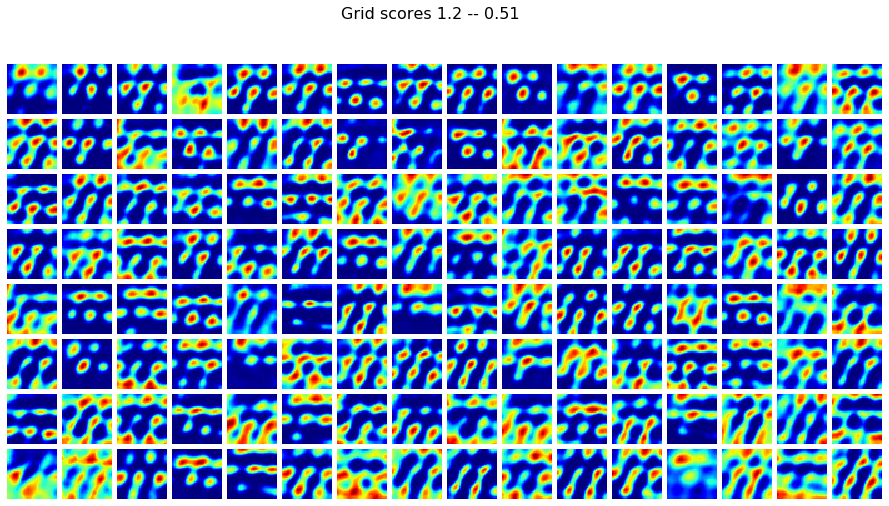

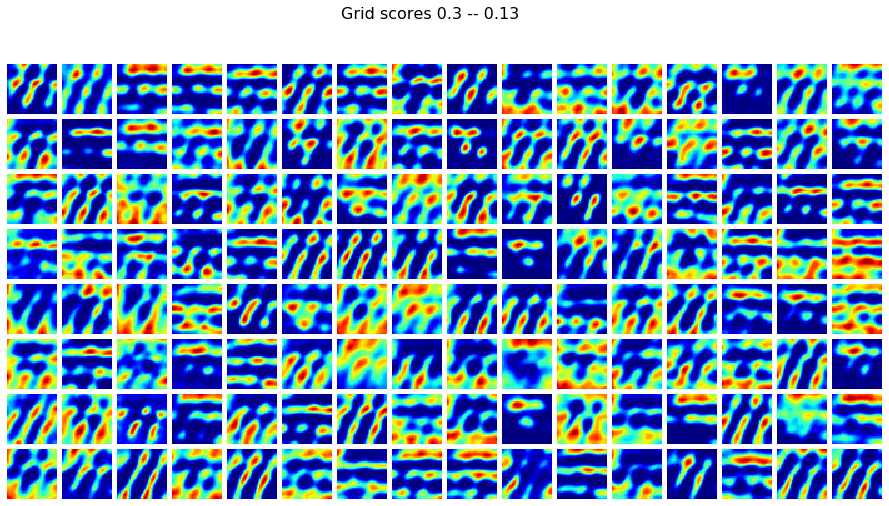

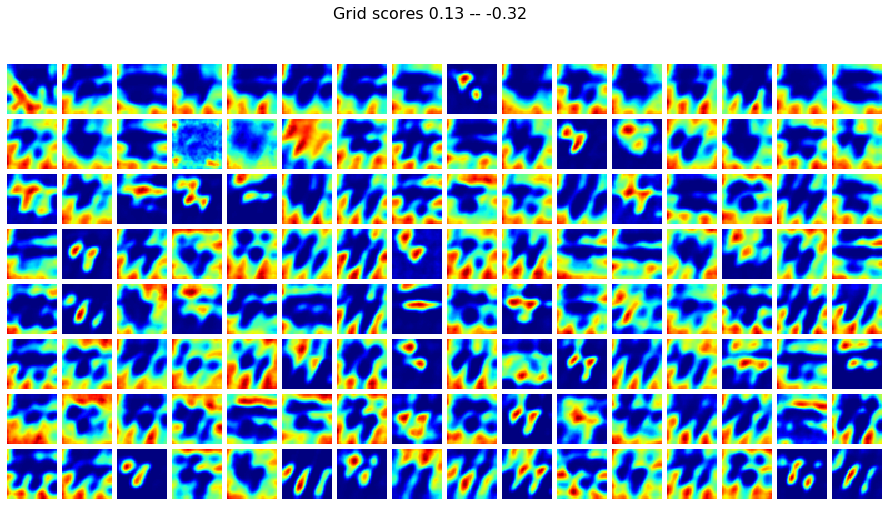

In [16]:
idxs = np.flip(np.argsort(score_60))
Ng = options.Ng

# Plot high grid scores
n_plot = 128
plt.figure(figsize=(16,4*n_plot//8**2))
rm_fig = plot_ratemaps(activations[idxs], n_plot, smooth=True)
plt.imshow(rm_fig)
plt.suptitle('Grid scores '+str(np.round(score_60[idxs[0]], 2))
             +' -- '+ str(np.round(score_60[idxs[n_plot]], 2)),
            fontsize=16)
plt.axis('off');

# Plot medium grid scores
plt.figure(figsize=(16,4*n_plot//8**2))
rm_fig = plot_ratemaps(activations[idxs[Ng//4:]], n_plot, smooth=True)
plt.imshow(rm_fig)
plt.suptitle('Grid scores '+str(np.round(score_60[idxs[Ng//2]], 2))
             +' -- ' + str(np.round(score_60[idxs[Ng//2+n_plot]], 2)),
            fontsize=16)
plt.axis('off');

# Plot low grid scores
plt.figure(figsize=(16,4*n_plot//8**2))
rm_fig = plot_ratemaps(activations[np.flip(idxs)], n_plot, smooth=True)
plt.imshow(rm_fig)
plt.suptitle('Grid scores '+str(np.round(score_60[idxs[-n_plot]], 2))
             +' -- ' + str(np.round(score_60[idxs[-1]], 2)),
            fontsize=16)
plt.axis('off');

In [22]:
#save activations for experiments
idxs = np.flip(np.argsort(score_60)) #idxs ordered by grid score
np.save('activationsr100',activations[idxs])

#save scores for experiments
#scores = np.sort(score_60)[::-1]
#np.save('scoresr',scores)

In [18]:
activations[0].shape

(40, 40)